# Problem Description:

This project is about a bank (Thera Bank) whose management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns
with better target marketing to increase the success ratio with a minimal budget.

## Objective:

The classification goal is to predict the likelihood of a liability customer buying personal loans.


## Attribute Information:
* ID: Customer ID
* Age: Customer's age in completed years
* Experience: #years of professional experience
* Income: Annual income of the customer
* ZIP Code: Home Address ZIP code.
* Family: Family size of the customer
* CCAvg: Avg. spending on credit cards per month
* Education: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
* Mortgage: Value of house mortgage if any.
* Personal Loan: Did this customer accept the personal loan offered in the last campaign?
* Securities Account: Doesthe customer have a securities account with the bank?
* CD Account: Doesthe customer have a certificate of deposit (CD) account with the bank?
* Online: Does the customer use internet banking facilities?
* Credit card: Doesthe customer use a credit card issued by the bank?

# Step 1. Importing and checking the dataset:

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
data=pd.read_csv('Bank_Personal_Loan_Modelling.csv')
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
print("The dataset consists of {} observation with {} features".format(*data.shape))

The dataset consists of 5000 observation with 14 features


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [5]:
# check to see if there is any null value
data.isnull().any()

ID                    False
Age                   False
Experience            False
Income                False
ZIP Code              False
Family                False
CCAvg                 False
Education             False
Mortgage              False
Personal Loan         False
Securities Account    False
CD Account            False
Online                False
CreditCard            False
dtype: bool

In [6]:
data.duplicated().any()

False

<b>Comment:</b> There are not null values nor duplicated rows in the dataset 

In [7]:
# getting data type
data.dtypes

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

In [8]:
# Number of unique items in each column
data.nunique()

ID                    5000
Age                     45
Experience              47
Income                 162
ZIP Code               467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal Loan            2
Securities Account       2
CD Account               2
Online                   2
CreditCard               2
dtype: int64

In [9]:
# ID is unique for any customer and does not provide useful information for modeling we should drop it
# ZIP code is categorical data but it has 467 unique items which make the encoded data super big so this column will be dropped as well
data.drop(['ID', 'ZIP Code'], axis=1, inplace=True)

## Data type:

* Age, experience, income, CCAvg, Mortgage are numerical data
* Family, Education, Personal Loan, Securities Account, CD Account, Online, CreditCard are categorical data

In [10]:
# converting to categorical data type:
cat_col=['Family', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
data[cat_col]=data[cat_col].astype('category')

In [11]:
# list of numerical data:
num_col=data.select_dtypes(np.number).columns
num_col

Index(['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage'], dtype='object')

In [12]:
# statistical summary of numerical data
data[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0


The minimum of all numerical data must be zero in this project. There are some negative numbers in the years of experience column that does not make sence we need to impute them

In [13]:
# Check for negative values and incorrect imputation
(data[num_col]<0).sum()

Age            0
Experience    52
Income         0
CCAvg          0
Mortgage       0
dtype: int64

There are 52 negative numbers in Experience column we can replace them with np.nan and impute them

In [14]:
data['Experience'].mask(data['Experience']<0, inplace=True)

In [15]:
# the negative values were converted to null values for imputation
data.isnull().sum()

Age                    0
Experience            52
Income                 0
Family                 0
CCAvg                  0
Education              0
Mortgage               0
Personal Loan          0
Securities Account     0
CD Account             0
Online                 0
CreditCard             0
dtype: int64

In [16]:
# imputing the missing data with column mean
imp=SimpleImputer(missing_values=np.nan, strategy="mean")
data["Experience"]=imp.fit_transform(data["Experience"].to_numpy().reshape(-1, 1)).astype('int64')

# Step 2) EDA and preparing data for model:

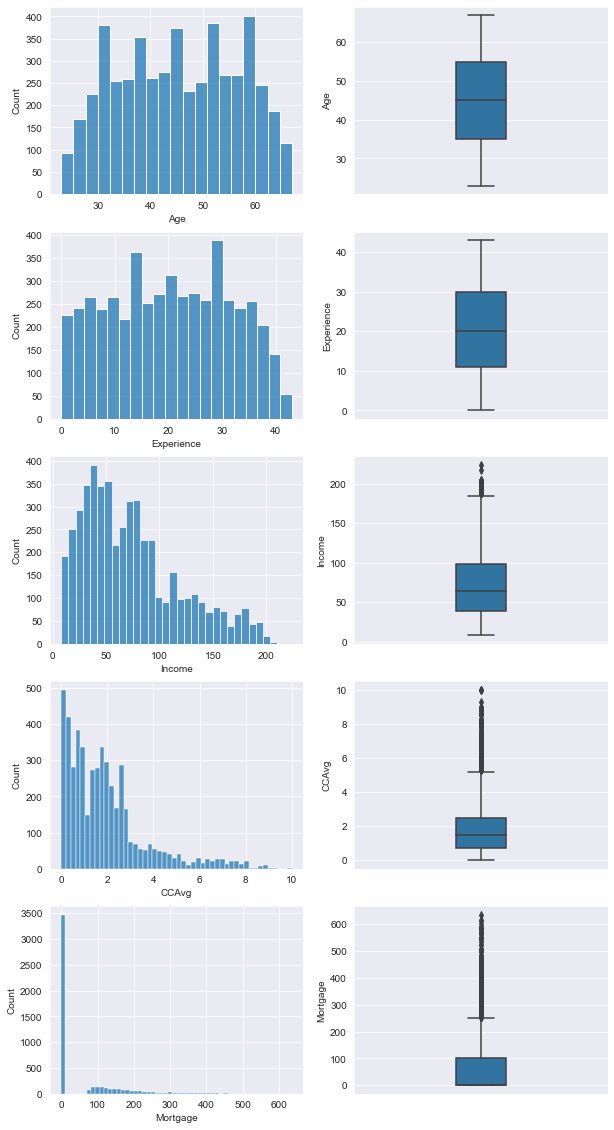

In [17]:
# distribution and boxplot of numerical data:
f, ax=plt.subplots(5,2,figsize=(10,20))
for i,col in enumerate(num_col):
    sns.histplot(data=data, x=col, ax=ax[i,0])
    sns.boxplot(data=data, y=col, width=0.2,ax=ax[i,1])

In [18]:
# checking skewness:
data[num_col].skew()

Age          -0.029341
Experience   -0.014100
Income        0.841339
CCAvg         1.598443
Mortgage      2.104002
dtype: float64

<b>Comment:</b> CCAvg and Mortgage distributions are very skewed. Income is also skewed. Mortgae has many zeros. We need to fix these issues before model building.

In [19]:
# number of people with zero mortgage
print(f"The number of people with zero Mortgage: {sum(data['Mortgage']==0)}")

The number of people with zero Mortgage: 3462


In [20]:
print(f"The number of people with zero credit card spending per month: {sum(data['CCAvg']==0)}")

The number of people with zero credit card spending per month: 106


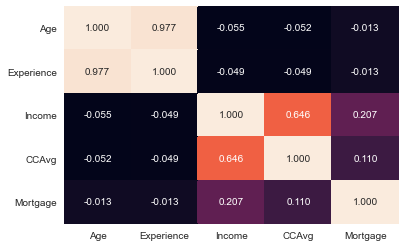

In [21]:
# Bivariate EDA:

sns.heatmap(data[num_col].corr(), annot=True, fmt='.3f', cbar=False);

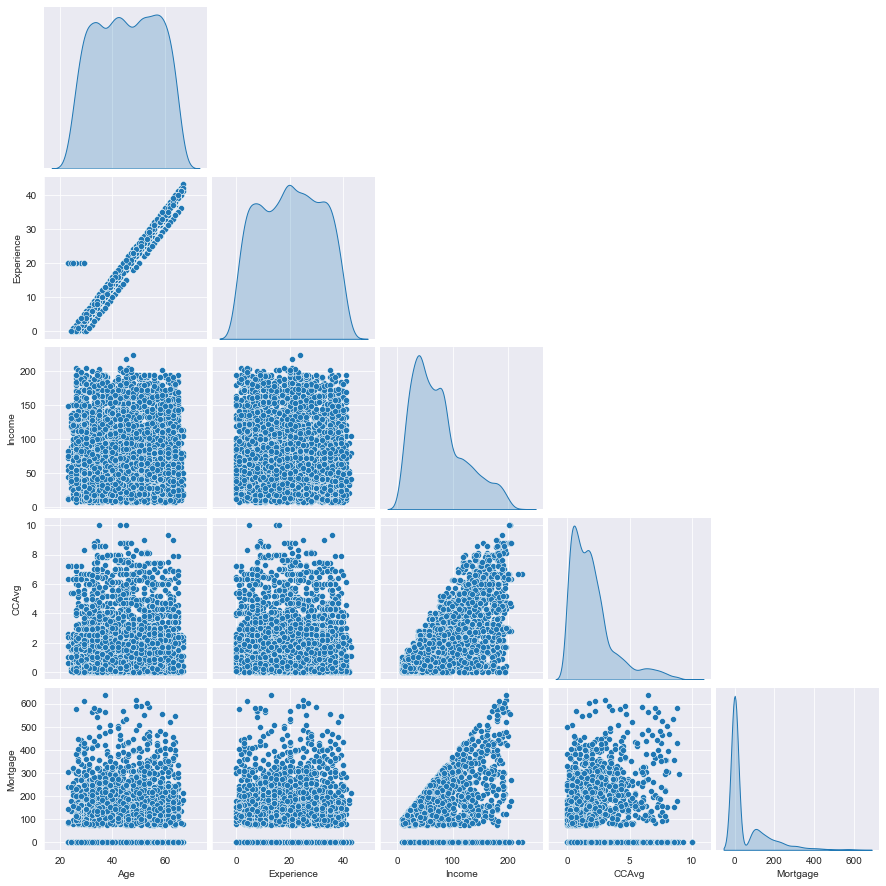

In [22]:
# Bivariate for non-categorical variables
sns.pairplot(data[num_col],diag_kind='kde',corner=True);

<b>Comment:</b> There is a strong correlation between age and experience

In [23]:
# EDA for Categorical data
for cat in cat_col:
    print(f'value counts of {cat}:\n{data[cat].value_counts()}\n-----------\n')

value counts of Family:
1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64
-----------

value counts of Education:
1    2096
3    1501
2    1403
Name: Education, dtype: int64
-----------

value counts of Personal Loan:
0    4520
1     480
Name: Personal Loan, dtype: int64
-----------

value counts of Securities Account:
0    4478
1     522
Name: Securities Account, dtype: int64
-----------

value counts of CD Account:
0    4698
1     302
Name: CD Account, dtype: int64
-----------

value counts of Online:
1    2984
0    2016
Name: Online, dtype: int64
-----------

value counts of CreditCard:
0    3530
1    1470
Name: CreditCard, dtype: int64
-----------



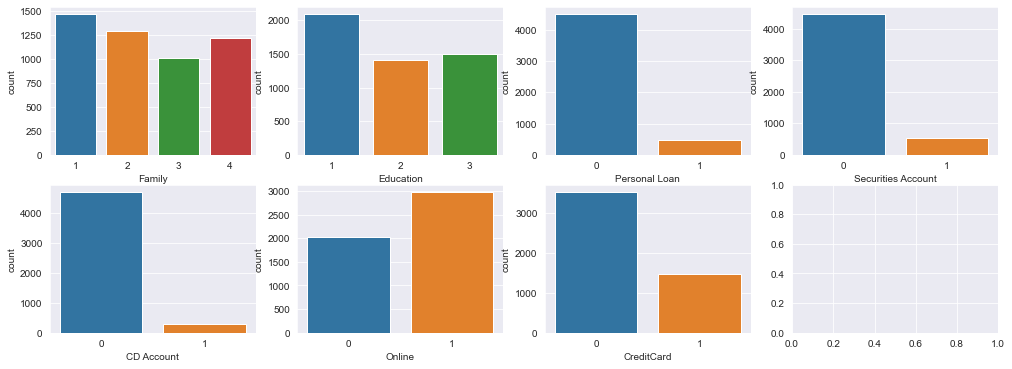

In [24]:
f,ax=plt.subplots(2,4, figsize=(17,6))
for i,col in enumerate(cat_col):
    sns.countplot(data=data, x=col, ax=ax[i//4, i%4])

<b>Comment:</b> Personal loan, CD Account, Securities Account are very unbalanced.

In [25]:
# Percentage of diferent education level in the sample dataset
data["Education"].value_counts(normalize=True).mul(100)

1    41.92
3    30.02
2    28.06
Name: Education, dtype: float64

In [26]:
# Couple of data related questions we can investigate before model building:
# 1) Do people with higher income has better chance of accepting personal loan?
# to answer this question we need to check if there is significant income difference between two groups

print(stats.ttest_ind(data[data["Personal Loan"]==0]["Income"], data[data["Personal Loan"]==1]["Income"]))
print(data.groupby("Personal Loan").mean()["Income"]);

Ttest_indResult(statistic=-41.08533291207552, pvalue=0.0)
Personal Loan
0     66.237389
1    144.745833
Name: Income, dtype: float64


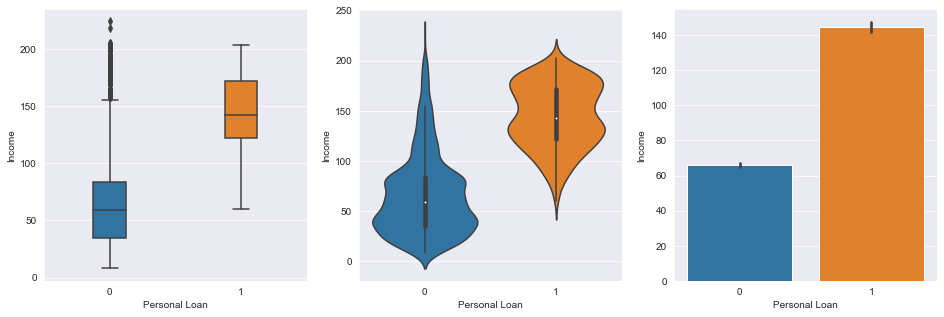

In [27]:
# checking visualy
f,ax=plt.subplots(1,3,figsize=(16,5))
sns.boxplot(x=data["Personal Loan"], y=data["Income"],width=0.25, ax=ax[0])
sns.violinplot(x=data["Personal Loan"],y=data["Income"], ax=ax[1])
sns.barplot(data=data, x='Personal Loan', y='Income', ax=ax[2]);

<b>Comment:</b> There is a significant difference in income between two groups

In [28]:
# 2) does people with higher education have higher income (or dose education make any difference in income)
# We can use ANOVA test
education_income=[np.array(data[data['Education']==l]['Income']) for l in data['Education'].unique()]
stats.f_oneway(*education_income)

F_onewayResult(statistic=125.30275492552306, pvalue=7.985513982293451e-54)

In [29]:
# the incomes among different educations are different
print(pairwise_tukeyhsd(data['Income'], data['Education']))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -21.2727  0.001 -24.9062 -17.6393   True
     1      3 -19.4638  0.001 -23.0255 -15.9021   True
     2      3    1.809 0.5233  -2.1026   5.7205  False
------------------------------------------------------


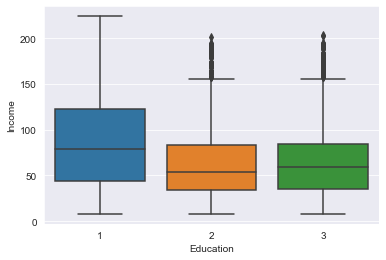

In [30]:
# visualization:
sns.boxplot(x=data["Education"],y=data["Income"]);

<b>Comment</b> There is significant differences between 1 and 2 as well as 1 and 3.

In [31]:
# 3) Does bigger families have higher income?
# statistical test:
stats.f_oneway(data[data["Family"]==1]["Income"],
               data[data["Family"]==2]["Income"],
               data[data["Family"]==3]["Income"],
               data[data["Family"]==4]["Income"])

F_onewayResult(statistic=61.81736608825173, pvalue=3.087041046404791e-39)

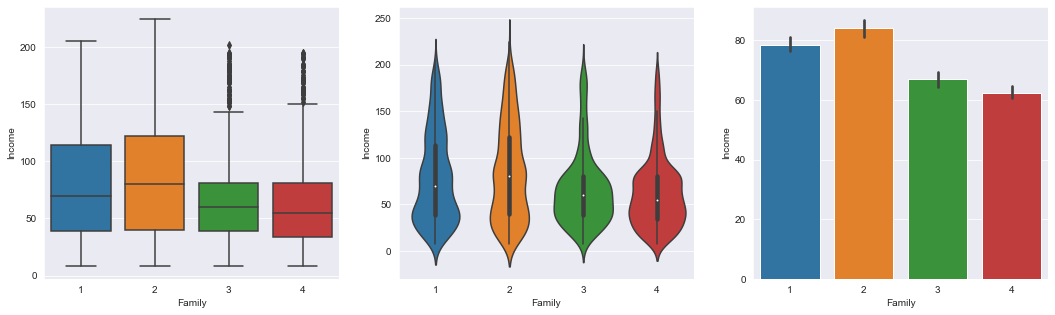

In [32]:

# visualization
f,ax=plt.subplots(1,3,figsize=(18,5))
sns.boxplot(data=data, x='Family', y='Income', ax=ax[0])
sns.violinplot(data=data, x="Family",y="Income", ax=ax[1])
sns.barplot(data=data,x="Family",y="Income",ax=ax[2]);
# answer: there is a significant difference among families income

In [33]:
# mean of numerical data for each outcome

data[num_col.append(pd.Index(['Personal Loan']))].groupby("Personal Loan").mean()

,Age,Experience,Income,CCAvg,Mortgage
Personal Loan,,,,,
0,45.367257,20.378982,66.237389,1.729009,51.789381
1,45.066667,19.843750,144.745833,3.905354,100.845833


In [34]:
# median of numerical data for each outcome
data[num_col.append(pd.Index(['Personal Loan']))].groupby("Personal Loan").median()

,Age,Experience,Income,CCAvg,Mortgage
Personal Loan,,,,,
0,45.0,20.0,59.0,1.4,0.0
1,45.0,20.0,142.5,3.8,0.0


Insights:
* No major difference in Age and Experience 
* we can check for difference in income and CCAvg using hypothesis tests

In [35]:
# testing for difference in income:
stats.ttest_ind(data[data["Personal Loan"]==0]["Income"], data[data["Personal Loan"]==1]["Income"])

Ttest_indResult(statistic=-41.08533291207552, pvalue=0.0)

In [36]:
# testing for difference in CCAvg:
stats.ttest_ind(data[data["Personal Loan"]==0]["CCAvg"], data[data["Personal Loan"]==1]["CCAvg"])

Ttest_indResult(statistic=-27.882127015069404, pvalue=3.8302661578168557e-159)

In both cases the p-value was below 0.05 so there is significant difference between two groups

In [37]:
# Bivariate analysis for categorical data:
pd.crosstab(data["Family"],data["Personal Loan"],normalize="columns")

Personal Loan,0,1
Family,,
1,0.301991,0.222917
2,0.263274,0.220833
3,0.194027,0.277083
4,0.240708,0.279167


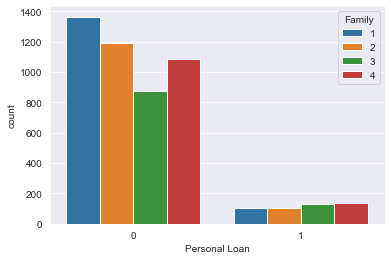

In [38]:
sns.countplot(data=data,x="Personal Loan",hue="Family");

In [39]:
pd.crosstab(data["Education"],data["Personal Loan"],normalize="columns")

Personal Loan,0,1
Education,,
1,0.443142,0.193750
2,0.270133,0.379167
3,0.286726,0.427083


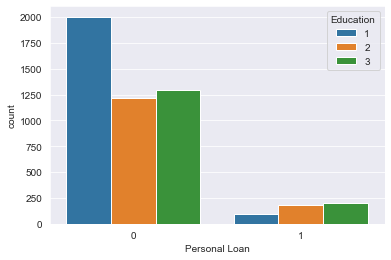

In [40]:
sns.countplot(data=data, x="Personal Loan", hue="Education");

## preparing data for model

The next step is to make the data ready for predictive model

there are couple of things to be done: 

1. imputing 
2. encoding 
3. scaling and transformation

There was no missing data but we had some negative values in experience so negative values were converted to nan and was imputed by mean. Additionally we need to deal with highly skewed features and encoding of categorical dat to numerical values

In [41]:
# transforming Income
data['Income']=data['Income'].apply(np.sqrt)

In [42]:
# Binarize Mortgage
data['Mortgage']=(data['Mortgage']>0).astype(int)

In [43]:
# We can bin CCAvg into 4 categories to treat skewnes
bining=KBinsDiscretizer(strategy='quantile', n_bins=4)
bined=bining.fit_transform(data['CCAvg'].values.reshape(-1,1))

In [44]:
[f'CCAvg_{i}_{j}' for i,j in zip(bining.bin_edges_[0][:-1], bining.bin_edges_[0][1:])]

['CCAvg_0.0_0.7', 'CCAvg_0.7_1.5', 'CCAvg_1.5_2.5', 'CCAvg_2.5_10.0']

In [45]:
bining.bin_edges_[0][:-1]

array([0. , 0.7, 1.5, 2.5])

In [46]:
df=pd.DataFrame(data=bined.toarray(), 
             columns=[f'CCAvg_{i}_{j}' for i,j in zip(bining.bin_edges_[0][:-1], bining.bin_edges_[0][1:])])

In [47]:
encoded_data=pd.concat([data, df],axis=1)
try:
    encoded_data=encoded_data.drop('CCAvg', axis=1)
except:
    pass
encoded_data.head()

,Age,Experience,Income,Family,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,CCAvg_0.0_0.7,CCAvg_0.7_1.5,CCAvg_1.5_2.5,CCAvg_2.5_10.0
0,25,1,7.000000,4,1,0,0,1,0,0,0,0.0,0.0,1.0,0.0
1,45,19,5.830952,3,1,0,0,1,0,0,0,0.0,0.0,1.0,0.0
2,39,15,3.316625,1,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0
3,35,9,10.000000,1,2,0,0,0,0,0,0,0.0,0.0,0.0,1.0
4,35,8,6.708204,4,2,0,0,0,0,0,1,0.0,1.0,0.0,0.0


In [48]:
encoded_data=pd.get_dummies(encoded_data, columns=['Family', 'Education'], drop_first=True)
encoded_data.head(10)

,Age,Experience,Income,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,CCAvg_0.0_0.7,CCAvg_0.7_1.5,CCAvg_1.5_2.5,CCAvg_2.5_10.0,Family_2,Family_3,Family_4,Education_2,Education_3
0,25,1,7.000000,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0,0,1,0,0
1,45,19,5.830952,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0,1,0,0,0
2,39,15,3.316625,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0,0,0,0
3,35,9,10.000000,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0,0,0,1,0
4,35,8,6.708204,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0,0,1,1,0
5,37,13,5.385165,1,0,0,0,1,0,1.0,0.0,0.0,0.0,0,0,1,1,0
6,53,27,8.485281,0,0,0,0,1,0,0.0,0.0,1.0,0.0,1,0,0,1,0
7,50,24,4.690416,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0,0,0,0,1
8,35,10,9.000000,1,0,0,0,1,0,1.0,0.0,0.0,0.0,0,1,0,1,0
9,34,9,13.416408,0,1,0,0,0,0,0.0,0.0,0.0,1.0,0,0,0,0,1


In [49]:
# Making features and labels from the dataset
# in this case we are using customer information to predict if the customer will accept the personal loan or not
# The label in this case is Personal Loan and everything else is feature

X=encoded_data.drop('Personal Loan',axis=1) # Features
y=encoded_data['Personal Loan'] # labels

In [50]:
X.head()

,Age,Experience,Income,Mortgage,Securities Account,CD Account,Online,CreditCard,CCAvg_0.0_0.7,CCAvg_0.7_1.5,CCAvg_1.5_2.5,CCAvg_2.5_10.0,Family_2,Family_3,Family_4,Education_2,Education_3
0,25,1,7.000000,0,1,0,0,0,0.0,0.0,1.0,0.0,0,0,1,0,0
1,45,19,5.830952,0,1,0,0,0,0.0,0.0,1.0,0.0,0,1,0,0,0
2,39,15,3.316625,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0,0,0,0
3,35,9,10.000000,0,0,0,0,0,0.0,0.0,0.0,1.0,0,0,0,1,0
4,35,8,6.708204,0,0,0,0,1,0.0,1.0,0.0,0.0,0,0,1,1,0


# Step 3) split dataset to train and test sets

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [53]:
# cheking the split:
print(f"Portion of train set: {len(x_train)/len(data)*100}")
print(f"Portion of test set: {len(x_test)/len(data)*100}")

Portion of train set: 70.0
Portion of test set: 30.0


In [54]:
# comparing the label distribution in original, train and test sets:
print(f"Original dataset-> (1: {sum(y)/len(y)*100:0.2f}%, 0: {sum(y==0)/len(y)*100:0.2f}%)")
print(f"Training dataset-> (1: {sum(y_train)/len(y_train)*100:0.2f}%, 0: {sum(y_train==0)/len(y_train)*100:0.2f}%)")
print(f"Test dataset->     (1: {sum(y_test)/len(y_test)*100:0.2f}%, 0: {sum(y_test==0)/len(y_test)*100:0.2f}%)")

Original dataset-> (1: 9.60%, 0: 90.40%)
Training dataset-> (1: 10.06%, 0: 89.94%)
Test dataset->     (1: 8.53%, 0: 91.47%)


# Step 4) Logistic Regression model

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
model=LogisticRegression(solver="liblinear")
model.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [57]:
# predicting labels for test set
y_predict=model.predict(x_test)

In [58]:
print(f"Model score (test set): {model.score(x_test, y_test)*100:.2f}%")
print(f"Model score (train set): {model.score(x_train,y_train)*100:.2f}%")

Model score (test set): 95.87%
Model score (train set): 96.29%


In [59]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report

In [60]:
cm=confusion_matrix(y_test,y_predict)
cm

array([[1359,   13],
       [  49,   79]], dtype=int64)

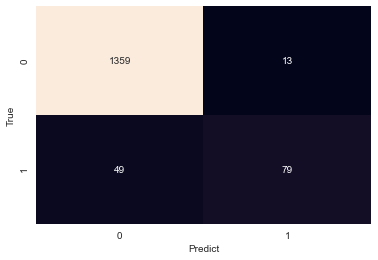

In [61]:
vis=sns.heatmap(cm,annot=True,fmt='d',cbar=False)
vis.set(xlabel='Predict',ylabel='True');

In [62]:
print(f"Accuracy:  {accuracy_score(y_test, y_predict)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_predict)*100:.2f}%")
print(f"recall:    {recall_score(y_test, y_predict)*100:.2f}%")

Accuracy:  95.87%
Precision: 85.87%
recall:    61.72%


In [63]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1372
           1       0.86      0.62      0.72       128

    accuracy                           0.96      1500
   macro avg       0.91      0.80      0.85      1500
weighted avg       0.96      0.96      0.96      1500



In [64]:
print(f"F1 score: {f1_score(y_test,y_predict)}")

F1 score: 0.7181818181818183


In [65]:
from sklearn.metrics import plot_roc_curve, roc_curve, auc, roc_auc_score

In [66]:
print(f"roc_auc score: {roc_auc_score(y_test, y_predict)}")

roc_auc score: 0.803856140670554


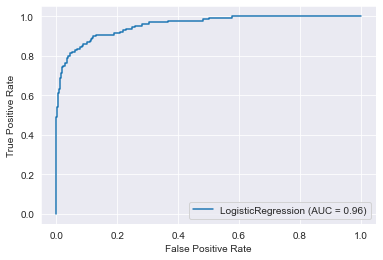

In [67]:
plot_roc_curve(model,x_test,y_test);

In [68]:
fpr,tpr,thr=roc_curve(y_test, y_predict)

In [69]:
# another way of obtaining ROC AUC score
auc(fpr,tpr)

0.803856140670554

In [70]:
from sklearn.metrics import plot_precision_recall_curve

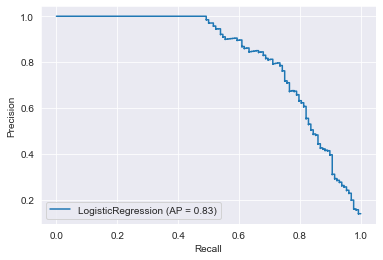

In [71]:
plot_precision_recall_curve(model,x_test,y_test);

# Step 5) Parameters of Logistic Regression

In [72]:
model.coef_

array([[-0.16521658,  0.15447192,  0.93556813,  0.27332119, -0.63125414,
         3.0917423 , -0.82725875, -0.88298164, -2.23162645, -1.92992635,
        -3.05273834, -0.67122916, -0.27093997,  1.47111683,  1.09705463,
         3.11986954,  3.07533582]])

In [73]:
model.intercept_

array([-7.88552029])

In [74]:
## Feature importance:
fi=pd.DataFrame()
fi["feature"]=x_train.columns
fi["Coeff"]=np.round(abs(model.coef_[0]),4)
fi.sort_values(by="Coeff", ascending=False)

,feature,Coeff
15,Education_2,3.1199
5,CD Account,3.0917
16,Education_3,3.0753
10,CCAvg_1.5_2.5,3.0527
8,CCAvg_0.0_0.7,2.2316
9,CCAvg_0.7_1.5,1.9299
13,Family_3,1.4711
14,Family_4,1.0971
2,Income,0.9356
7,CreditCard,0.8830


# Step 6) Business Insight

True Positive (observed=1, predicted=1):
Predicted customer is a good candidate for loan campaign and the customer accepted the loan in the first campaign

False Positive (observed=0, Predicted=1):
Predicted customer is a good candidate for loan campaign while the customer did not accept the loan in the first campaign

True Negative (observed=0, Predicted=0):
Predicted customer is not a good candidate for loan campaign and the customer did not accept the loan in the first campaign

False Negative (observed=1, Predicted=0):
Predicted customer is not a good candidate for loan campaign while the customer accepted the loan in the first campaign

The predictive model has a low recall score (~62%), which means it labels 38% of potential customers as "not a good cadidate for loan". 

The model prediction has ~86% precision, which means 86% of the people selected by the model for loan compaign are actually good candidates.

Therefore, the current model (under the current settings) may be inaccurate for targeted loan campaign. We can tune the model parameters or use a different type of classification method. 

It should be noted that in the current dataset only 9.6% of people accepted the personal loan. This may make the model bias to label customers as "not a good candidate", so maybe collecting more data can improve the the model metrics.

In [75]:
# Using Random Forest Classifier:

from sklearn.ensemble import RandomForestClassifier

In [76]:
clf=RandomForestClassifier()
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.9826666666666667

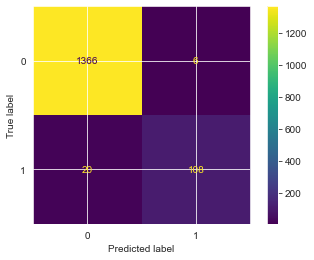

In [77]:
plot_confusion_matrix(clf,x_test,y_test);

In [78]:
print(classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1372
           1       0.95      0.84      0.89       128

    accuracy                           0.98      1500
   macro avg       0.97      0.92      0.94      1500
weighted avg       0.98      0.98      0.98      1500



<b>Comment:</b> Recall and precision scores were improved by using Random Forest classifier